In [1]:
import os

# common math imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# common audio imports
import librosa

# common torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# common sklearn imports 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [125]:
input_folder = 'birdclef-2022/train_audio'
output_folder = 'test'

In [129]:
# import json
# with open(params_file) as f:
#     params = json.load(f)

# shift_std = float(params['bird_present']['shift_std'])
# frame_duration = float(params['bird_present']['frame_duration'])
# hop_scalar = float(params['bird_present']['hop_scalar'])
# rate_present = float(params['bird_present']['rate_present'])
# num_seconds = float(params['bird_present']['num_seconds'])
# max_kbps = float(params['bird_present']['max_kbps'])
# nmels = int(params['bird_present']['n_mels'])
# sr_all = int(params['bird_present']['sr_all'])

shift_std = 1.
frame_duration = 0.1
hop_scalar = 1.
rate_present = 0.01
num_seconds = 5.
max_kbps = 100.0
sr_all = 32_000
n_mels = 32

alphabet = 'ab'

frame_length = int(frame_duration * 32_000)
hop_length = int(frame_length * hop_scalar)
max_size_bytes = int(max_kbps * 1024)
# Calculate the number of frames corresponding to 5 seconds
frames_per_s = int((sr_all * num_seconds) // hop_length)

sequence_size = 1


In [130]:
# Find all subfolders (bird species) in the main train_audio directory
bird_folders = [os.path.join(input_folder, d) for d in os.listdir(input_folder)
                if os.path.isdir(os.path.join(input_folder, d))]
bird_names = [os.path.basename(d) for d in bird_folders]
bird_names = np.unique(bird_names).tolist()
bird_names = ['no_bird'] + bird_names
birdname_to_label = {name: idx for idx, name in enumerate(bird_names)}
bird_names

['no_bird',
 'afrsil1',
 'akekee',
 'akepa1',
 'akiapo',
 'akikik',
 'amewig',
 'aniani',
 'apapan',
 'arcter',
 'barpet',
 'bcnher',
 'belkin1',
 'bkbplo',
 'bknsti',
 'bkwpet',
 'blkfra',
 'blknod',
 'bongul',
 'brant',
 'brnboo',
 'brnnod',
 'brnowl',
 'brtcur',
 'bubsan',
 'buffle',
 'bulpet',
 'burpar',
 'buwtea',
 'cacgoo1',
 'calqua',
 'cangoo',
 'canvas',
 'caster1',
 'categr',
 'chbsan',
 'chemun',
 'chukar',
 'cintea',
 'comgal1',
 'commyn',
 'compea',
 'comsan',
 'comwax',
 'coopet',
 'crehon',
 'dunlin',
 'elepai',
 'ercfra',
 'eurwig',
 'fragul',
 'gadwal',
 'gamqua',
 'glwgul',
 'gnwtea',
 'golphe',
 'grbher3',
 'grefri',
 'gresca',
 'gryfra',
 'gwfgoo',
 'hawama',
 'hawcoo',
 'hawcre',
 'hawgoo',
 'hawhaw',
 'hawpet1',
 'hoomer',
 'houfin',
 'houspa',
 'hudgod',
 'iiwi',
 'incter1',
 'jabwar',
 'japqua',
 'kalphe',
 'kauama',
 'laugul',
 'layalb',
 'lcspet',
 'leasan',
 'leater1',
 'lessca',
 'lesyel',
 'lobdow',
 'lotjae',
 'madpet',
 'magpet1',
 'mallar3',
 'masboo',
 

In [132]:
y = []
X = []
z = []
W = []
zero_mels = np.zeros((n_mels, frames_per_s), dtype=np.float32)
for bird_folder in bird_folders:
    bird_name = os.path.basename(bird_folder)
    files = [f for f in os.listdir(bird_folder) if f.endswith('.ogg')]


    if bird_name[0] not in alphabet:
        break
    print(bird_name)



    for file in files:

        file_path = os.path.join(bird_folder, file)
        # do not load if the file is too large
        if os.path.getsize(file_path) > max_size_bytes:
            continue

        # load and process the file here
        audio, sr = librosa.load(file_path, sr=None)

        # what are the dangers of me downsampling to 32kHz?
        if sr != sr_all:
            continue

        # check if the audio has no bird
        shift_amplitude = np.std(audio) * shift_std
        zcr = librosa.feature.zero_crossing_rate(audio + shift_amplitude,
                                                 frame_length=frame_length,
                                                 hop_length=hop_length,
                                                 ).squeeze()
        W.append(zcr.tolist())
        zcr_present = zcr > rate_present
        window_size = int(num_seconds / frame_duration)
        try:
            pad_length = (-len(zcr_present)) % window_size
            if pad_length > 0:
                zcr_present = np.pad(zcr_present, (0, pad_length), constant_values=False)
            zcr_windowed = np.add.reduceat(zcr_present, np.arange(0, len(zcr), window_size))
            labels_present = np.where(zcr_windowed > 0, bird_name, 'no_bird')
        except:
            # if the audio is too short, just skip it
            print(f"Skipping {file_path} due to length issues.")
            break

        # convert to categorical labels
        labels_categorical = np.array([birdname_to_label[label] for label in labels_present])

        # compute the Mel spectrogram for the audio
        S = librosa.feature.melspectrogram(y=audio, 
                                           sr=sr, 
                                           n_mels=n_mels, 
                                           fmax=None, 
                                           hop_length=hop_length)

        # pad S with zeros if needed so its second dimension is a multiple of frames_per_5s
        num_frames = S.shape[1]
        pad_width = (-num_frames) % frames_per_s
        if pad_width > 0:
            S = np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
            
        # slice the Mel spectrogram into 5-second units
        mel_slices = []
        num_slices = S.shape[1] // frames_per_s
        for i in range(num_slices):
            start = i * frames_per_s
            end = start + frames_per_s
            mel_slices.append(S[:, start:end])
        mel_slices = np.array(mel_slices, dtype=np.float32)

        # check and manipulate sizes of the audio file
        curr_len = len(labels_categorical)
        addi_len = sequence_size - curr_len

        # The audio file is shorter than the sequence size
        # Pad the labels and mel_slices to match the sequence size
        if addi_len > 0:
            labels_categorical = np.pad(labels_categorical, (0, addi_len), constant_values=0)
            # print(len(labels_categorical))
            mel_slices = np.pad(mel_slices, ((0, addi_len), (0, 0), (0, 0)), mode='constant')
            y.append(labels_categorical)
            X.append(mel_slices)
            z.append(file_path)
        # The audio file exactly fits the sequence size
        elif addi_len == 0:
            y.append(labels_categorical)
            X.append(mel_slices)
            z.append(file_path)
        # The audio file is longer than the sequence size
        # Split the labels and mel_slices into chunks of sequence size
        # and add them to the batch
        elif addi_len < 0:
            labels_categorical_many = np.array_split(labels_categorical, np.arange(sequence_size, len(labels_categorical), sequence_size))
            mel_slices_many = np.array_split(mel_slices, np.arange(sequence_size, len(mel_slices), sequence_size))
            # Pad the last split if it's shorter than sequence_size
            if len(labels_categorical_many[-1]) < sequence_size:
                pad_len = sequence_size - len(labels_categorical_many[-1])
                labels_categorical_many[-1] = np.pad(labels_categorical_many[-1], (0, pad_len), constant_values=0)
                mel_slices_many[-1] = np.pad(mel_slices_many[-1], ((0, pad_len), (0, 0), (0, 0)), mode='constant')
            for lbls, mels in zip(labels_categorical_many, mel_slices_many):
                y.append(lbls)
                X.append(mels)
                z.append(file_path)

# Train the neural network here

y = np.array(y, dtype=np.int64)
X = np.array(X, dtype=np.float32)
y_tensor = torch.tensor(y, dtype=torch.uint8)
X_tensor = torch.tensor(X, dtype=torch.float16)



afrsil1
akekee
akepa1
akiapo
akikik
amewig
aniani
apapan
arcter
barpet
bcnher
belkin1
bkbplo
bknsti
bkwpet
blkfra
Skipping birdclef-2022/train_audio/blkfra/XC649198.ogg due to length issues.
blknod
bongul
brant
brnboo
brnnod
brnowl
brtcur
bubsan
buffle
bulpet
burpar
buwtea


In [ ]:
# saving the data
# bird names for categories
with open(output_folder + "/birds.csv",'w') as f:
    for i in range(len(bird_names)):
        f.write(f"{i},{bird_names[i]}\n")
# where the files came from
with open(output_folder + "/files.csv","w") as f:
    for _ in z:
        f.write(f"{_}\n")
# the zero crossing rates
# which will not be aligned with the mel spectrograms
# but will be useful for debugging
with open(output_folder + "/zc_rates.csv","w") as f:
    for w in W:
        try:
            for _ in w:
                f.write(f"{round(_,4)},")
            f.write("\n")
        except:
            f.write(f'{round(w,4)},\n')

# X has shape (batch_size, height, width)
X_cnn = torch.flatten(X_tensor, end_dim=1).unsqueeze(1)
y_cnn = torch.flatten(y_tensor, end_dim=1)
torch.save(X_cnn, output_folder + '/X_tensor.pt')
torch.save(y_cnn, output_folder + '/y_tensor.pt')

0.009375


In [140]:
[len(w) for w in W]

TypeError: object of type 'float' has no len()

In [114]:
torch.save(X_tensor, 'X_tensor_small.pt')
torch.save(y_tensor, 'y_tensor_small.pt')

In [99]:
# X has shape (batch_size, height, width)
X_cnn = torch.flatten(X_tensor, end_dim=1).unsqueeze(1)
y_cnn = torch.flatten(y_tensor, end_dim=1)

dataset = TensorDataset(X_cnn, y_cnn)

# Create a DataLoader with shuffling enabled
batch_size = 50  # You can adjust the batch size as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [100]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, stratify=y_cnn, random_state=42
)

# Print the sizes of the splits
print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Training data size: 917
Testing data size: 230


In [101]:
class CNN_2D(nn.Module):
    def __init__(self, num_classes, in_channels=1, 
                 out_channels1=16, out_channels2=32,
                 fc_hidden_units=64, 
                 kernel_size=3, stride=1, padding=1,
                 pooling_size=2, dropout=0.5):
        super(CNN_2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels1, 
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(out_channels1, out_channels2, 
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.pool = nn.MaxPool2d(pooling_size, pooling_size)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.LazyLinear(fc_hidden_units)
        self.fc2 = nn.Linear(fc_hidden_units, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [102]:
# Example usage
input_length = X_cnn.shape[1]  # Replace with your actual input length
num_classes = len(bird_names)  # Number of unique categories in y_encoded
cnn_model = CNN_2D(num_classes,)
print(cnn_model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Choose an optimizer for training
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)  # Adjust learning rate and momentum as needed
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # You can adjust the learning rate
# optimizer = optim.RMSprop(cnn_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # I know less about these

# Training loop
num_epochs = 50  # Number of epochs to train
for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(data_loader):.4f}")

CNN_2D(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
Epoch 1/50, Loss: 1.1849
Epoch 2/50, Loss: 1.0039
Epoch 3/50, Loss: 0.9330
Epoch 4/50, Loss: 0.8872
Epoch 5/50, Loss: 0.8440
Epoch 6/50, Loss: 0.8170
Epoch 7/50, Loss: 0.7609
Epoch 8/50, Loss: 0.7407
Epoch 9/50, Loss: 0.6845
Epoch 10/50, Loss: 0.6481
Epoch 11/50, Loss: 0.6272
Epoch 12/50, Loss: 0.6068
Epoch 13/50, Loss: 0.6546
Epoch 14/50, Loss: 0.6093
Epoch 15/50, Loss: 0.5549
Epoch 16/50, Loss: 0.5099
Epoch 17/50, Loss: 0.5094
Epoch 18/50, Loss: 0.5314
Epoch 19/50, Loss: 0.4799
Epoch 20/50, Loss: 0.4707
Epoch 21/50, Loss: 0.4659
Epoch 22/50, Loss: 0.4567
Epoch 23/50, Loss: 0.471

In [104]:
# Evaluate the model's accuracy on the training data
cnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in train_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Training Accuracy: {accuracy:.2f}%")

CNN model
Training Accuracy: 87.24%


In [105]:
# Evaluate the model's accuracy on the training data
cnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Training Accuracy: {accuracy:.2f}%")

CNN model
Training Accuracy: 71.30%


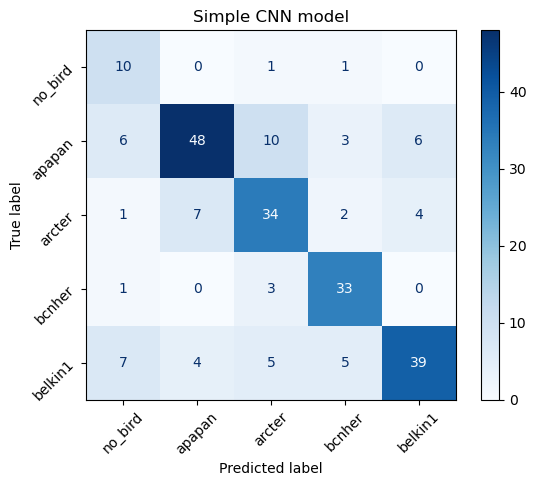

In [106]:
# Collect all predictions and true labels
all_predictions = []
all_true_labels = []

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cnn)

cnn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        outputs = cnn_model(inputs)

        # Get the predicted class (index of the maximum value in the output)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
# Invert numeric labels back to bird_names for display
disp_labels = [bird_names[i] for i in range(len(bird_names))]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.title('Simple CNN model')

plt.show()